<a href="https://colab.research.google.com/github/ParthPanchall/Pneumonia-Detection-Deployment/blob/master/Pneumonia_Detection_Using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Step 1`: Importing the dataset

In [1]:
# Installing kaggle
!pip install -q kaggle

In [2]:
# To upload kaggle json file from the local systems
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chandurobbi","key":"29e7a02a2948be67ac9c3b5c3f5e9937"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Create a kaggle directory
!mkdir ~/.kaggle

In [5]:


# Copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

In [6]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:14<00:00, 283MB/s]
100% 2.29G/2.29G [00:14<00:00, 171MB/s]


# `Step 2`: Unzip the dataset and make directories

In [8]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [9]:
# Import the helper function and  get the functions needed that we are going to need in this notebook
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-05 09:39:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-10-05 09:40:00 (13.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [10]:
from helper_functions import walk_through_dir, plot_loss_curves

In [11]:
import shutil
shutil.rmtree("/content/chest_xray/__MACOSX")
shutil.rmtree("/content/chest_xray/chest_xray")

In [12]:
walk_through_dir("/content/chest_xray")

There are 3 directories and 0 images in '/content/chest_xray'.
There are 2 directories and 0 images in '/content/chest_xray/test'.
There are 0 directories and 390 images in '/content/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in '/content/chest_xray/test/NORMAL'.
There are 2 directories and 0 images in '/content/chest_xray/train'.
There are 0 directories and 3875 images in '/content/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in '/content/chest_xray/train/NORMAL'.
There are 2 directories and 0 images in '/content/chest_xray/val'.
There are 0 directories and 8 images in '/content/chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in '/content/chest_xray/val/NORMAL'.


In [13]:
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_images(target_dir, target_class):
  # Setup the target directory
  target_folder = target_dir + target_class

  # Get the random image path
  rand_img = random.sample(os.listdir(target_folder), 1)

  # Read the image and plot
  img = mpimg.imread(target_folder + "/" + rand_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False);

  print(f"Image shape :{img.shape}")

  return img

Image shape :(584, 1008)


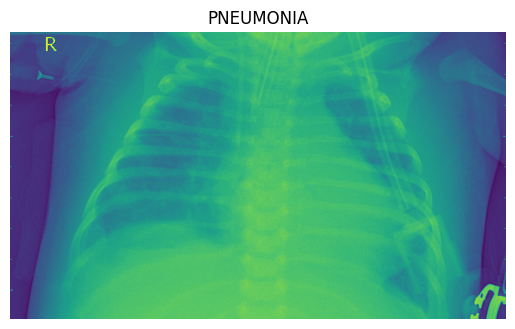

In [14]:
img = view_random_images(target_dir="/content/chest_xray/train/",
                         target_class="PNEUMONIA")

Image shape :(1093, 1522)


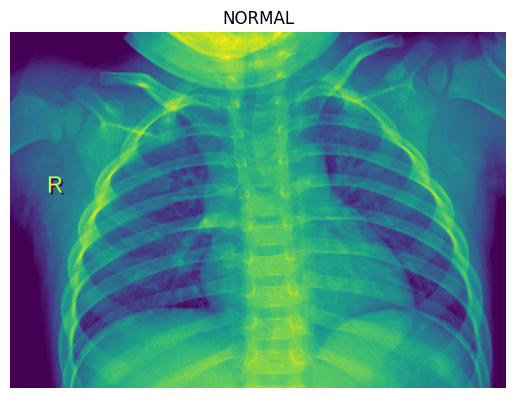

In [15]:
img = view_random_images(target_dir="/content/chest_xray/train/",
                         target_class="NORMAL")

# Preparing the data for modelling


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1. Preprocessing the data (getting the values between 0 and 1)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

# 2. Setting and getting the path of our directories
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

# 3. Importing the data from the directories and turn it into the batches
print("Train Data")
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                                                 batch_size=32,
                                                                 target_size=(224, 224),
                                                                 class_mode="binary",
                                                                 seed=42)

print("Test Data")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=32,
                                                                target_size=(224,224),
                                                                class_mode="binary",
                                                                seed=42)

print("Val Data")
val_data = val_datagen.flow_from_directory(directory=val_dir,
                                                                batch_size=32,
                                                                target_size=(224,224),
                                                                class_mode="binary",
                                                                seed=42)



Train Data
Found 5216 images belonging to 2 classes.
Test Data
Found 624 images belonging to 2 classes.
Val Data
Found 16 images belonging to 2 classes.


In [17]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 11.0 MB/s eta 

# `Step 3`: Modelling


In [21]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Pneumonia Detection/tuned_resnet.h5")

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [23]:
model.evaluate(test_data)

20/20 [==============================] - 18s 360ms/step - loss: 0.2026 - accuracy: 0.9439


[0.20261278748512268, 0.9439102411270142]

In [24]:
import numpy as np
def pneumoniaPrediction(img):
    img = np.array(img)/255
    img = img.reshape(1, 224, 224, 3)
    isPneumonic = model.predict(img)[0]
    imgClass = "Normal" if isPneumonic<0.5 else "Pneumonic"
    return imgClass

In [25]:
pr = model.predict(test_data)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=1
    else:
        pr[i]=0

20/20 [==============================] - 6s 245ms/step


In [26]:
import gradio as gr
img = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=1)

<ipython-input-26-4e6200b165ec>:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  img = gr.inputs.Image(shape=(224,224))
<ipython-input-26-4e6200b165ec>:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  img = gr.inputs.Image(shape=(224,224))
<ipython-input-26-4e6200b165ec>:3: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=1)
<ipython-input-26-4e6200b165ec>:3: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=1)


In [ ]:
interface = gr.Interface(fn = pneumoniaPrediction,
                            title = "Pneumonia Detection using Chest X-Ray",
                            inputs = img,
                            outputs = label,
                            interpretation = "default")
interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://30eeef82dc35f292e7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 1s 1s/step
